# Data preprocessing

## Goals: 

* All the images belongs to the same leaf, must be assigned to one of the training or testing dataset. 
* The classes distributions within training and testing dataset should be close to the whole dataset.

## Reference:
https://github.com/salathegroup/plantvillage_deeplearning_paper_analysis

## Notes:
If you want to reproduce our paper results, you can directly use the .txt files in dataset/??-??/ directory, where ? is a digit.

In [1]:
from __future__ import division
import glob
import csv
import random
import numpy as np
import os
import math
import json
import torch
from torch.utils.data import Dataset
from ImageFolderData import ImageFolder
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
INPUT_FOLDER = "/home/h/Downloads/color"
OUTPUT_FOLDER = "/home/h/Downloads/plantvillage_deeplearning_paper_dataset"

#VALID_PERCENT = 20
TEST_PERCENT = 50
data_separate = '50-50'

## Step 1： Generating hash mapping  which takes the last few characters of the image's filename as the key and the class name plus image's digit ID as its value.

In [3]:
MAP = {}
for _csvfile in glob.glob(os.path.join(OUTPUT_FOLDER, "filtered_leafmaps/*.csv")):
    csvfile = open(_csvfile, "r")
    reader = csv.DictReader(csvfile)
    _key = _csvfile.split("/")[-1].split(".")[0] # csv filename
    for row in reader:
        # "File Name","Leaf #"
        # "FREC_Scab 2907.JPG","1.0"
        _filename = ".".join(row['File Name'].split(".")[:-1]) # FREC_Scab 2907
        #print(_filename)
        #break
        _leaf_id = row['Leaf #']

        _leaf_id = _key+":::"+_leaf_id

        _filename = _filename.lower().strip()
        #print(_filename)
        #break
        try:
            MAP[_filename].append(_leaf_id)
        except:
            MAP[_filename] = [_leaf_id]
    csvfile.close()

for _key in MAP.keys():
    if len(MAP[_key])>1:
        print(_key, " ------ ", MAP[_key])

rs_hl 5715  ------  ['Soybean___healthy:::349.0', 'Apple___healthy:::13.0']
rs_hl 5451  ------  ['Soybean___healthy:::308.0', 'Blueberry___healthy:::154.0']
rs_hl 4426  ------  ['Soybean___healthy:::193.0', 'Strawberry___healthy:::73.0']
rs_hl 6285  ------  ['Soybean___healthy:::401.0', 'Apple___healthy:::107.0']
rs_hl 5996  ------  ['Soybean___healthy:::377.0', 'Apple___healthy:::60.0']
rs_hl 0556  ------  ['Tomato___healthy:::139.0', 'Blueberry___healthy:::34.0']
rs_hl 5277  ------  ['Soybean___healthy:::287.0', 'Blueberry___healthy:::144.0']
rs_hl 0358  ------  ['Tomato___healthy:::89.0', 'Blueberry___healthy:::7.0']
rs_hl 5008  ------  ['Soybean___healthy:::256.0', 'Blueberry___healthy:::125.0']
rs_hl 5970  ------  ['Soybean___healthy:::376.0', 'Apple___healthy:::55.0']
rs_hl 6257  ------  ['Soybean___healthy:::399.0', 'Apple___healthy:::102.0']
rs_hl 0427  ------  ['Tomato___healthy:::107.0', 'Blueberry___healthy:::15.0']
rs_hl 4889  ------  ['Soybean___healthy:::243.0', 'Blueberr

rs_hl 6107  ------  ['Soybean___healthy:::387.0', 'Apple___healthy:::77.0']
rs_hl 5356  ------  ['Soybean___healthy:::296.0', 'Blueberry___healthy:::148.0']
rs_hl 4724  ------  ['Soybean___healthy:::226.0', 'Strawberry___healthy:::100.0']
rs_hl 5310  ------  ['Soybean___healthy:::291.0', 'Blueberry___healthy:::145.0']
rs_hl 6131  ------  ['Soybean___healthy:::389.0', 'Apple___healthy:::81.0']
rs_hl 5854  ------  ['Soybean___healthy:::367.0', 'Apple___healthy:::36.0']
rs_hl 5781  ------  ['Soybean___healthy:::360.0', 'Apple___healthy:::24.0']
rs_hl 6269  ------  ['Soybean___healthy:::399.0', 'Apple___healthy:::104.0']
rs_hl 7546  ------  ['Soybean___healthy:::509.0', 'Apple___healthy:::170.0']
rs_hl 6151  ------  ['Soybean___healthy:::391.0', 'Apple___healthy:::85.0']
rs_hl 7448  ------  ['Soybean___healthy:::500.0', 'Apple___healthy:::156.0']
rs_hl 7492  ------  ['Soybean___healthy:::504.0', 'Apple___healthy:::162.0']
rs_hl 6041  ------  ['Soybean___healthy:::382.0', 'Apple___healthy::

In [6]:
f=open("filtered_leafmaps/leaf-map.json", "w")
f.write(json.dumps(MAP))
f.close()

## Step2: Establish the training, validation, and testing .txt files

In [4]:
with open('filtered_leafmaps/leaf-map.json', 'r') as f:
    leaf_map = json.loads(f.read())

In [6]:
def determine_leaf_group(leaf_identifier, className):
    """
    If the image shown in the leaf map, this will
    return the value stored in leaf map, or the small group
    of images belong to the same one leaf in the same class.
    Otherwise, return a random number, which means
    each image refers to a unique leaf. (e.g. for corn)
    leaf_identifier: a leaf image file name
    className: class name of a dir that this image belongs to
    """
    global leaf_map
    try:
        foo = leaf_map[leaf_identifier.lower().strip()]
        #foo == ['Pepper_bell___healthy:::79.0']
        if len(foo) == 1:
            return foo[0]
        else:
            for _suggestion in foo:
                if _suggestion.find(className) != -1:
                    return _suggestion
            return str(random.randint(1,1e22))
    except:
        return str(random.randint(1,1e22))

In [7]:
def compute_per_class_distribution(DATASET):
    classMap = {}
    count = 0
    for datum in DATASET:
        try:
            classMap[datum[1]].append(datum[0])
            count += 1
        except:
            classMap[datum[1]] = datum[0]
            count += 1
    for _key in classMap:
        classMap[_key] = len(classMap[_key])
    return classMap

In [8]:
def distribute_buckets(BUCKETS, test_prob):
    train = []
    test = []
    
    for _key in BUCKETS.keys():
        bucket = BUCKETS[_key]
        random_prb = random.random()
        if random_prb <= 1-test_prob:
            train += bucket
        else:
            test += bucket
    return train, test

In [9]:
all_images = glob.glob(INPUT_FOLDER+'/*/*')
print(all_images[0:1])

['./color/Pepper_bell___healthy/14765754-33b2-427b-8583-05d8604384e1___JR_HL 5891.JPG']


In [10]:
BUCKETS = {}
for _img in all_images:
    image_name = _img.split('/')[-1]
    className = _img.split('/')[-2]
    
    #Check if the image belongs to a particular known group
    image_identifier = image_name.replace("_final_masked","")
    image_identifier = image_identifier.split("___")[-1]	
    image_identifier = image_identifier.split("copy")[0].replace(".jpg", "").replace(".JPG","").replace(".png","").replace(".PNG", "")
    
    group = determine_leaf_group(image_identifier, className)
    try:
        BUCKETS[group].append((_img, className))
    except:
        BUCKETS[group] = [(_img, className)]
    #print(image_name, "======================>", group)
    #break
    # add all the images of the same leaf 
    # to the train or valid or test set

In [11]:
# cut and copy lines from test.txt to valid.txt
import fileinput
def gen_dataset_txt_file(test_perc):
    CANDIDATE_DISTRIBUTIONS = []
    CANDIDATE_VARIANCES = []
    for k in range(1000): # try 1000 gen times
        train, test = distribute_buckets(BUCKETS, test_perc)
        train_dist = compute_per_class_distribution(train)
        #valid_dist = compute_per_class_distribution(valid)
        test_dist = compute_per_class_distribution(test)
        spread_data = [] # each class made up to how much proportional to the whole data
        for _key in train_dist:
            # _key: className, train_dist[_key]: #images in the class 
            spread_data.append(train_dist[_key] * 1.0 /(train_dist[_key]+test_dist[_key]))#+valid_dist[_key]
        
        CANDIDATE_DISTRIBUTIONS.append((train, test))#valid,
        CANDIDATE_VARIANCES.append(np.var(spread_data))
    train, test = CANDIDATE_DISTRIBUTIONS[np.argmax(CANDIDATE_VARIANCES)] #valid,
    # choose the largest variance between different classes' proportion to the whole data
    print(len(train))
    #print(len(valid))
    print(len(test))
    
    train_dist = compute_per_class_distribution(train)
    #valid_dist = compute_per_class_distribution(valid)
    test_dist = compute_per_class_distribution(test)
    
    spread_data = []
    for _key in train_dist:
        print(_key, train_dist[_key] * 1.0 /(train_dist[_key]+test_dist[_key])) #+valid_dist[_key]
        spread_data.append(train_dist[_key] * 1.0 /(train_dist[_key]+test_dist[_key])) #+valid_dist[_key]
    
    print( "Mean :: ", np.mean(spread_data) )
    print( "Variance: ", np.var(spread_data) )
    
    target_folder_name = str(int(math.ceil((1-test_perc)*100)))+"-"+str(int(math.ceil(test_perc*100)))
    try:
        os.mkdir(OUTPUT_FOLDER+"/"+target_folder_name)
    except:
        pass
    
    labels_map = {}
    for _entry in train:
        try:
            labels_map[_entry[1]] += 1
        except:
            labels_map[_entry[1]] = 0
    print(labels_map)
    labels_list = sorted(labels_map.keys())
    
    f = open(OUTPUT_FOLDER+"/"+target_folder_name+"/train.txt","w")
    train_txt = ""
    for _entry in train:
        train_txt += os.path.abspath(_entry[0])+"\t"+str(labels_list.index(_entry[1]))+"\n"
    f.write(train_txt)
    f.close()
    """
    f = open(OUTPUT_FOLDER+"/"+target_folder_name+"/valid.txt","w")
    valid_txt = ""
    for _entry in valid:
        valid_txt += os.path.abspath(_entry[0])+"\t"+str(labels_list.index(_entry[1]))+"\n"
    f.write(valid_txt)
    f.close()
    """
    f = open(OUTPUT_FOLDER+"/"+target_folder_name+"/test.txt","w")
    test_txt = ""
    for _entry in test:
        test_txt += os.path.abspath(_entry[0])+"\t"+str(labels_list.index(_entry[1]))+"\n"
    f.write(test_txt)
    f.close()
    
    f = open(OUTPUT_FOLDER+"/"+target_folder_name+"/labels.txt","w")
    f.write("\n".join(labels_list))
    f.close()
    
    f = open(OUTPUT_FOLDER+"/"+target_folder_name+"/valid.txt","w")
    fr = fileinput.input(OUTPUT_FOLDER+"/"+target_folder_name+"/test.txt", inplace=True)
    for l, lcontent in enumerate(fr):
        if l < 5430:
            f.write(lcontent)
            #next(fr, None)
        else:
            f.close()
            print(lcontent, end='')
        
    return train, test

In [27]:
train, test = gen_dataset_txt_file(TEST_PERCENT/100) #valid, 

43477
10828
Tomato___Early_blight 0.5
Strawberry___healthy 0.5
Grape___healthy 0.5
Pepper_bell___Bacterial_spot 0.5
Strawberry___Leaf_scorch 0.5
Apple___Apple_scab 0.5
Tomato___Tomato_mosaic_virus 0.5
Orange___Haunglongbing_Citrus_greening 0.5
Corn_maize___Northern_Leaf_Blight 0.4824120603015075
Squash___Powdery_mildew 0.5027932960893855
Soybean___healthy 0.5
Tomato___Spider_mites_Two-spotted_spider_mite 0.5
Blueberry___healthy 0.5
Potato___healthy 0.5
Tomato___Bacterial_spot 0.5130890052356021
Tomato___Tomato_Yellow_Leaf_Curl_Virus 0.4861111111111111
Tomato___Leaf_Mold 0.5
Apple___Cedar_apple_rust 0.5
Tomato___healthy 0.5125
Raspberry___healthy 0.5
Peach___healthy 0.5
Cherry_including_sour___Powdery_mildew 0.5
Tomato___Septoria_leaf_spot 0.5026178010471204
Peach___Bacterial_spot 0.5
Grape___Esca_Black_Measles 0.5
Tomato___Target_Spot 0.5
Grape___Leaf_blight_Isariopsis_Leaf_Spot 0.5
Apple_Frogeye_Spot 0.5
Corn_maize___Cercospora_leaf_spot Gray_leaf_spot 0.4890829694323144
Grape___Black

## Step 3: Visualization the dataset

In [3]:
def data_class_num_dict(datasettxtfile):
    labels_map = {}
    with open(datasettxtfile, 'r') as f:
        dataset = f.read().splitlines()
    for _entry in dataset:
        l = int(_entry[-2:])# maximum 38
        try:
            labels_map[l] += 1
        except:
            labels_map[l] = 1
    return labels_map

In [4]:
train_class_num_dict = data_class_num_dict(OUTPUT_FOLDER+"/"+str(100-TEST_PERCENT)+"-"+str(TEST_PERCENT)+"/train.txt")
valid_class_num_dict = data_class_num_dict(OUTPUT_FOLDER+"/"+str(100-TEST_PERCENT)+"-"+str(TEST_PERCENT)+"/valid.txt")
test_class_num_dict = data_class_num_dict(OUTPUT_FOLDER+"/"+str(100-TEST_PERCENT)+"-"+str(TEST_PERCENT)+"/test.txt")
print(train_class_num_dict)
print(valid_class_num_dict)
print(test_class_num_dict)

{0: 362, 1: 274, 2: 163, 3: 842, 4: 774, 5: 531, 6: 384, 7: 229, 8: 567, 9: 491, 10: 603, 11: 616, 12: 692, 13: 512, 14: 205, 15: 2622, 16: 1126, 17: 183, 18: 515, 19: 847, 20: 476, 21: 496, 22: 76, 23: 181, 24: 2406, 25: 919, 26: 580, 27: 222, 28: 1080, 29: 532, 30: 934, 31: 456, 32: 917, 33: 844, 34: 712, 35: 2697, 36: 179, 37: 749}
{0: 82, 1: 96, 2: 20, 3: 129, 4: 180, 5: 80, 6: 98, 7: 50, 8: 125, 9: 99, 10: 100, 11: 128, 12: 143, 13: 124, 14: 51, 15: 471, 16: 205, 17: 40, 18: 99, 19: 145, 20: 132, 21: 64, 22: 20, 23: 30, 24: 535, 25: 209, 26: 119, 27: 58, 28: 192, 29: 104, 30: 174, 31: 100, 32: 196, 33: 148, 34: 131, 35: 545, 36: 35, 37: 173}
{0: 177, 1: 260, 2: 92, 3: 674, 4: 548, 5: 441, 6: 372, 7: 234, 8: 500, 9: 395, 10: 459, 11: 436, 12: 548, 13: 440, 14: 167, 15: 2414, 16: 966, 17: 137, 18: 383, 19: 486, 20: 392, 21: 440, 22: 56, 23: 160, 24: 2149, 25: 707, 26: 410, 27: 176, 28: 855, 29: 364, 30: 801, 31: 396, 32: 658, 33: 684, 34: 561, 35: 2115, 36: 159, 37: 669}


In [5]:
valid_test_num_dict = {}
for k, v in valid_class_num_dict.items():
    valid_test_num_dict[k] = v + test_class_num_dict[k]
print(valid_test_num_dict)

{0: 259, 1: 356, 2: 112, 3: 803, 4: 728, 5: 521, 6: 470, 7: 284, 8: 625, 9: 494, 10: 559, 11: 564, 12: 691, 13: 564, 14: 218, 15: 2885, 16: 1171, 17: 177, 18: 482, 19: 631, 20: 524, 21: 504, 22: 76, 23: 190, 24: 2684, 25: 916, 26: 529, 27: 234, 28: 1047, 29: 468, 30: 975, 31: 496, 32: 854, 33: 832, 34: 692, 35: 2660, 36: 194, 37: 842}


In [6]:
idx_to_class_name = {}
with open(OUTPUT_FOLDER+"/"+str(100-TEST_PERCENT)+"-"+str(TEST_PERCENT)+"/labels.txt") as f:
    dataset = f.read().splitlines()
    for i, _entry in enumerate(dataset):
        idx_to_class_name[i] = _entry
print(idx_to_class_name)

{0: 'Apple_Frogeye_Spot', 1: 'Apple___Apple_scab', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_including_sour___Powdery_mildew', 6: 'Cherry_including_sour___healthy', 7: 'Corn_maize___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_maize___Common_rust_', 9: 'Corn_maize___Northern_Leaf_Blight', 10: 'Corn_maize___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_Black_Measles', 13: 'Grape___Leaf_blight_Isariopsis_Leaf_Spot', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_Citrus_greening', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper_bell___Bacterial_spot', 19: 'Pepper_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'Tomato___Leaf_Mold', 

In [7]:
whole_dataset_dict = {}
for k, train_v in train_class_num_dict.items():
    whole_dataset_dict[k] = train_class_num_dict[k] + valid_class_num_dict[k] + test_class_num_dict[k]
print(whole_dataset_dict)

{0: 621, 1: 630, 2: 275, 3: 1645, 4: 1502, 5: 1052, 6: 854, 7: 513, 8: 1192, 9: 985, 10: 1162, 11: 1180, 12: 1383, 13: 1076, 14: 423, 15: 5507, 16: 2297, 17: 360, 18: 997, 19: 1478, 20: 1000, 21: 1000, 22: 152, 23: 371, 24: 5090, 25: 1835, 26: 1109, 27: 456, 28: 2127, 29: 1000, 30: 1909, 31: 952, 32: 1771, 33: 1676, 34: 1404, 35: 5357, 36: 373, 37: 1591}


In [8]:
tc = 0
for v in whole_dataset_dict.values():
    tc += v
print(tc)

54305


In [9]:
kwargs = {'num_workers': 2, 'pin_memory': True}
leaf_train_loader = torch.utils.data.DataLoader(
    ImageFolder('/home/h/Downloads/plantvillage_deeplearning_paper_dataset'
                , data_type='train'
                , data_separate = data_separate
                , transform=transforms.Compose([
                    transforms.Scale(64),
                    #transforms.CenterCrop(224),
                    transforms.ToTensor()
                    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
               ), 
    batch_size=200, shuffle=False, **kwargs)
def show_labeled_cifar_batch(images_batch):
    """Show image for a batch of samples."""
    batch_size = len(images_batch)# torch image: C x H x W
    images_batch = images_batch.numpy().transpose((1, 2, 0)) # numpy image: H x W x C
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #images_batch = std * images_batch + mean # unnormalize
    plt.figure(figsize=(images_batch.shape[0],images_batch.shape[1]))
    plt.axis('off')
    plt.imshow(images_batch) 
    plt.pause(0.001) #pause a bit so that plots are updated

/home/h/dl/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [39]:
irange = range
def make_grid(tensor, nrow=8, padding=2,
              normalize=False, range=None, scale_each=False, pad_value=255):
    """Make a grid of images.
    Args:
        tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
            or a list of images all of the same size.
        nrow (int, optional): Number of images displayed in each row of the grid.
            The Final grid size is (B / nrow, nrow). Default is 8.
        padding (int, optional): amount of padding. Default is 2.
        normalize (bool, optional): If True, shift the image to the range (0, 1),
            by subtracting the minimum and dividing by the maximum pixel value.
        range (tuple, optional): tuple (min, max) where min and max are numbers,
            then these numbers are used to normalize the image. By default, min and max
            are computed from the tensor.
        scale_each (bool, optional): If True, scale each image in the batch of
            images separately rather than the (min, max) over all images.
        pad_value (float, optional): Value for the padded pixels.
    Example:
        See this notebook `here <https://gist.github.com/anonymous/bf16430f7750c023141c562f3e9f2a91>`_
    """
    if not (torch.is_tensor(tensor) or
            (isinstance(tensor, list) and all(torch.is_tensor(t) for t in tensor))):
        raise TypeError('tensor or list of tensors expected, got {}'.format(type(tensor)))

    # if list of tensors, convert to a 4D mini-batch Tensor
    if isinstance(tensor, list):
        tensor = torch.stack(tensor, dim=0)

    if tensor.dim() == 2:  # single image H x W
        tensor = tensor.view(1, tensor.size(0), tensor.size(1))
    if tensor.dim() == 3:  # single image
        if tensor.size(0) == 1:  # if single-channel, convert to 3-channel
            tensor = torch.cat((tensor, tensor, tensor), 0)
        tensor = tensor.view(1, tensor.size(0), tensor.size(1), tensor.size(2))

    if tensor.dim() == 4 and tensor.size(1) == 1:  # single-channel images
        tensor = torch.cat((tensor, tensor, tensor), 1)

    if normalize is True:
        tensor = tensor.clone()  # avoid modifying tensor in-place
        if range is not None:
            assert isinstance(range, tuple), \
                "range has to be a tuple (min, max) if specified. min and max are numbers"

        def norm_ip(img, min, max):
            img.clamp_(min=min, max=max)
            img.add_(-min).div_(max - min + 1e-5)

        def norm_range(t, range):
            if range is not None:
                norm_ip(t, range[0], range[1])
            else:
                norm_ip(t, t.min(), t.max())

        if scale_each is True:
            for t in tensor:  # loop over mini-batch dimension
                norm_range(t, range)
        else:
            norm_range(tensor, range)

    if tensor.size(0) == 1:
        return tensor.squeeze()

    # make the mini-batch of images into a grid
    nmaps = tensor.size(0)
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.size(2) + padding), int(tensor.size(3) + padding)
    #grid = tensor.new(3, height * ymaps + padding, width * xmaps + padding).fill_(pad_value)
    grid = tensor.new(height * ymaps + padding, width * xmaps + padding, 3).fill_(pad_value)
    k = 0
    for y in irange(ymaps):
        for x in irange(xmaps):
            if k >= nmaps:
                break
            tensor_np = tensor[k].cpu().numpy().transpose((1, 2, 0)).copy()
            tensor_with_label = cv2.putText(tensor_np,'('+str(k)+')', (0,11), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,50,250),2)
            tensor_with_label = torch.from_numpy(tensor_with_label)#.transpose((2, 0, 1))
            
            grid.narrow(0, y * height + padding, height - padding)\
                .narrow(1, x * width + padding, width - padding)\
                .copy_(tensor_with_label)
            k = k + 1
    return grid

In [40]:
targets_imgs = {}
selected_imgs = []
for real_imgs, _, targets in leaf_train_loader:
    #print(' '.join('%5s' % classes[targets[j]] for j in range(20)))
    if len(targets_imgs) == 38:
        break
    for i, target in enumerate(targets):
        if target not in targets_imgs.keys():
            targets_imgs[target] = real_imgs[i]
keylist = targets_imgs.keys()
sorted(keylist)

for k in keylist:
    selected_imgs.append(targets_imgs[k])
out = make_grid(selected_imgs, nrow=6, pad_value=0)
print(keylist)
#show_labeled_cifar_batch(out)
#print(targets[0])
#plt.imshow(real_imgs[0].numpy().transpose((1, 2, 0)).squeeze())
del real_imgs, targets, targets_imgs, selected_imgs

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37])


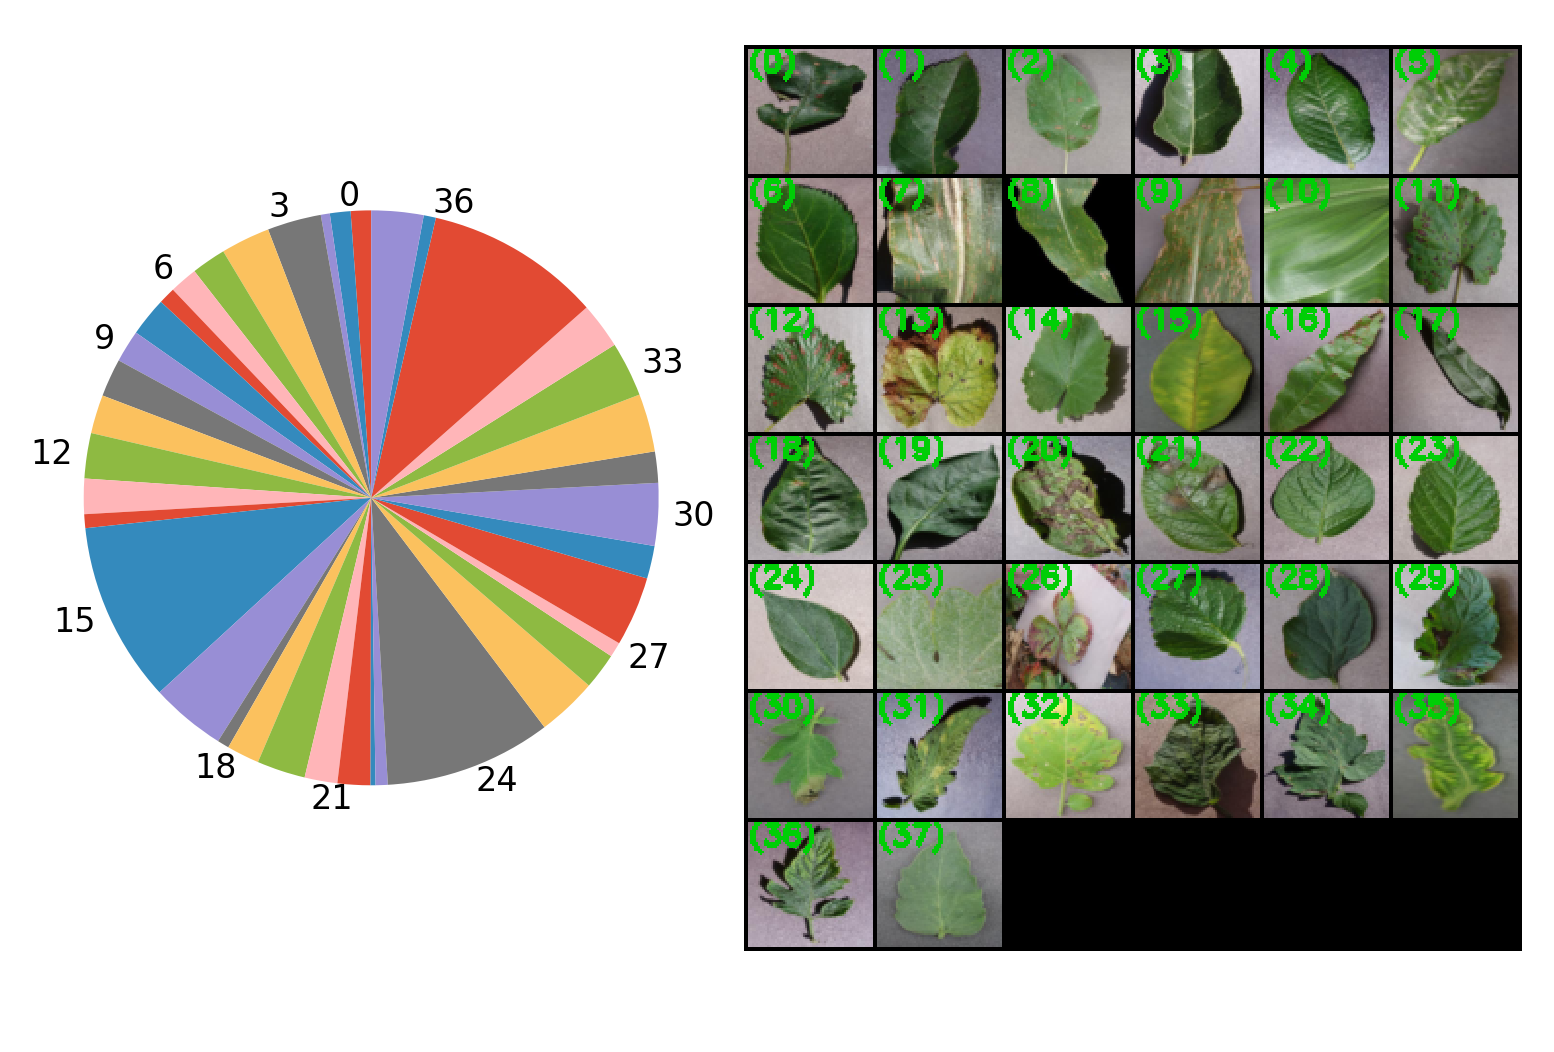

In [41]:
# http://www.howtobuildsoftware.com/index.php/how-do/cqy2/python-matplotlib-plot-pie-chart-how-to-avoid-overlapping-of-labels-autopct-in-a-matplotlib-pie-chart
from __future__ import division
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
plt.style.use('ggplot')
fig = plt.figure(dpi=300)
gs = GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0, 0])
label = [idx for idx in whole_dataset_dict.keys()]
sizes = [v for v in whole_dataset_dict.values()]
ax.axis('equal')

patches, texts = ax.pie(sizes,labels=label, radius=1.7, labeldistance=1.05# autopct='%1.1f%%',
        ,shadow=False, startangle=90)
for i, text in enumerate(texts):
    if i % 3 == 0:
        text.set_fontsize(8)
    else:
        text.set_text('')
#labels=['%s: %1.2f %%' % (l, s/tc*100) for l, s in zip(label, sizes)]
#ax.legend(patches, labels, loc=2, bbox_to_anchor=(0, 0.02), ncol=4,fontsize=10)

ax1= plt.subplot(gs[0, 1])
batch_size = len(out)# torch image: C x H x W
#out = out.numpy().transpose((1, 2, 0)) # numpy image: H x W x C
out = out.numpy()
plt.figure(figsize=(out.shape[0]/2,out.shape[1]/2))
ax1.axis('off')
ax1.imshow(out) 
plt.pause(0.001)
plt.show()
paper_img_dir = '/home/h/Documents/bmc_template/images'
fig.savefig(os.path.join(paper_img_dir,'Fig_2_dataset.png'), dpi=fig.dpi, bbox_inches='tight')
del out

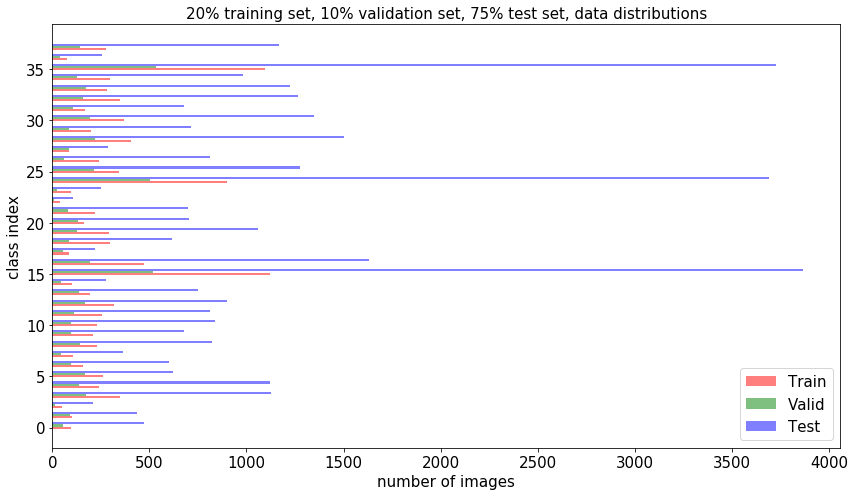

In [66]:
ind = np.arange(len(train_class_num_dict.keys()))

width = 0.20       # the width of the bars

fig, ax = plt.subplots(figsize=(12,7))
#plt.xticks(rotation='vertical')
rects1 = ax.barh(ind, train_class_num_dict.values(), width, color='r',  alpha=0.5)
rects2 = ax.barh(ind+ width, valid_class_num_dict.values(), width, color='g', alpha=0.5)#bottom=train_class_num_dict.values()
rects3 = ax.barh(ind+ 2*width, test_class_num_dict.values(), width, color='b', alpha=0.5)

ax.set_xlabel('number of images',size=15)
ax.set_ylabel('class index',size=15)
ax.set_title('20% training set, 10% validation set, 75% test set, data distributions',size=15)
#ax.set_xticks(ind + 1.5*width)
#ax.set_xticklabels(ind)
ax.legend((rects1[0], rects2[0], rects3[0]), ('Train', 'Valid', 'Test'), fontsize=15)
ax.tick_params(labelsize=15)
"""
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
"""
plt.tight_layout()
plt.show()

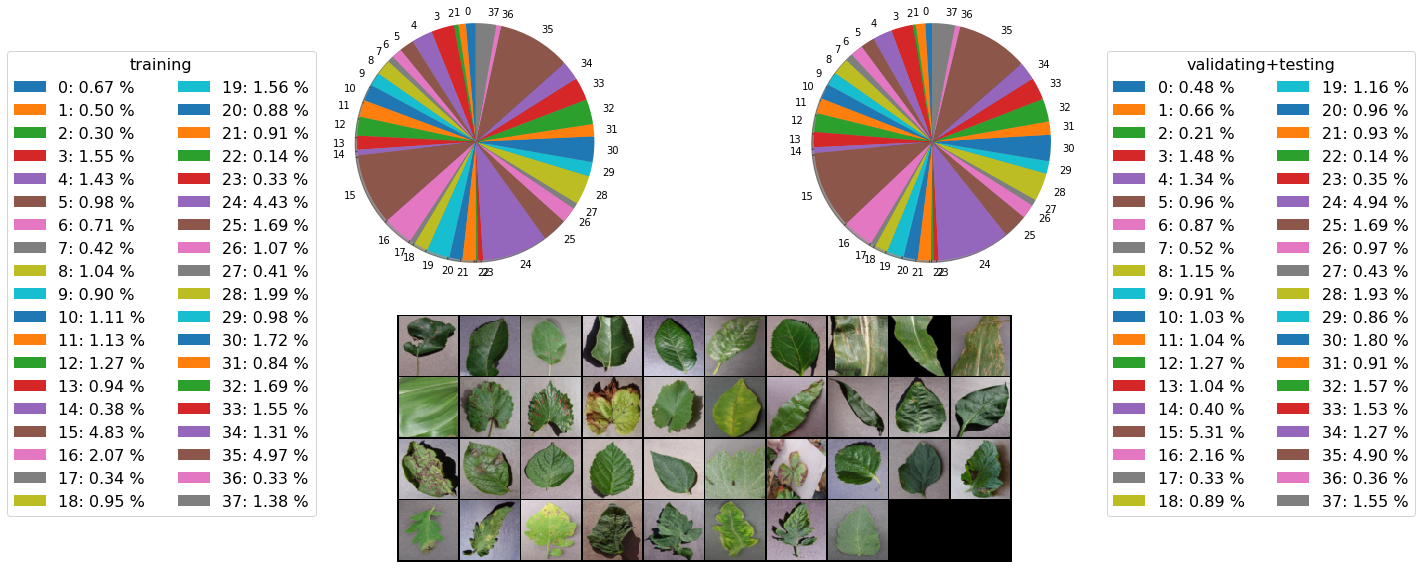

In [32]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
cmap = plt.get_cmap('gnuplot')

colors = [cmap(i) for i in np.linspace(0, 1, 38)]
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
fig = plt.figure( figsize=(15,10))
gs = GridSpec(2, 2)
ax = plt.subplot(gs[0, 0])
#plt.tight_layout()
#ax.set_title(u'training', fontsize=20)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#label = [idx_to_class_name[idx] for idx in train_class_num_dict.keys()]
label = [idx for idx in train_class_num_dict.keys()]
sizes = [v for v in train_class_num_dict.values()]
patches, texts = ax.pie(sizes,labels=label,radius=1.2,
        shadow=True, startangle=90)
for text in texts:
    text.set_fontsize(10)
labels=['%s: %1.2f %%' % (l, s/tc*100) for l, s in zip(label, sizes)]
lg = plt.legend(patches, labels, loc='best',title='training', bbox_to_anchor=(0.1, 0.9), ncol=2,
           prop={'size': 16},
           fontsize=16)
lg.get_title().set_fontsize(16)

ax1 = plt.subplot(gs[0, 1])
#plt.tight_layout()
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.set_title('validating+testing', fontsize=20)
#label = [idx_to_class_name[idx] for idx in valid_test_num_dict.keys()]
label = [idx for idx in valid_test_num_dict.keys()]
sizes = [v for v in valid_test_num_dict.values()]
patches, texts = ax1.pie(sizes,labels=label,radius=1.2,
        shadow=True, startangle=90)
for text in texts:
    text.set_fontsize(10)
labels=['%s: %1.2f %%' % (l, s/tc*100) for l, s in zip(label, sizes)]
lg = plt.legend(patches, labels, loc='best',title='validating+testing', bbox_to_anchor=(1.79, 0.9), ncol=2,
           #prop=FontProperties(size='xx-large'),
           fontsize=16)
lg.get_title().set_fontsize(16)

ax2 = plt.subplot(gs[1, 0:2])
batch_size = len(out)# torch image: C x H x W
out = out.numpy().transpose((1, 2, 0)) # numpy image: H x W x C
plt.figure(figsize=(out.shape[0]/2,out.shape[1]/2))
ax2.axis('off')
ax2.imshow(out) 
plt.pause(0.001)
plt.show()
del out